In [35]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate, Reshape, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from code.modelhelper import *

In [29]:
CVECT = 100
UCHARS = 139
NCLASS = 2
BATCH_SIZE = 200
EPOCHS = 300

In [3]:
m1 = load_model("models/dl/m1.h5")
m2 = load_model("models/dl/m2.h5")
m3 = load_model("models/dl/m3.h5")

W0826 17:36:15.155206  4392 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
x_feat = np.load("data/xy/x_feat_45_15.npy")
x_char = np.load("data/xy/x_char_onehot_45_15.npz")["arr_0"]
x_word = np.load("data/xy/x_word_45_15.npy")
y = np.load("data/xy/y_onehot_45_15.npy")

In [7]:
xf_train, xf_test, y_train, y_test = train_test_split(
    x_feat,
    y,
    test_size=0.2,
    random_state=11
)

xc_train, xc_test, y_train, y_test = train_test_split(
    x_char,
    y,
    test_size=0.2,
    random_state=11
)

xw_train, xw_test, y_train, y_test = train_test_split(
    x_word,
    y,
    test_size=0.2,
    random_state=11
)

In [8]:
for layer in m1.layers:
    layer.trainable = False
    
for layer in m2.layers:
    layer.trainable = False
    
for layer in m3.layers:
    layer.trainable = False

In [19]:
model_input = concatenate(
    [
        m1.get_layer("m1_dense3").output,
        m2.get_layer("m2_gru_2").output,
        m3.get_layer("m3_lstm").output,
    ]
)

H = Reshape((32+256+32, 1), name="fusion_reshape")(model_input)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_1"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_1")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_2"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_2")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_3"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_3")(H)

H = Conv1D(
    filters=32,
    kernel_size=2,
    padding="same",
    activation="tanh",
    name="fusion_conv1d_4"
)(H)
H = MaxPool1D(2, name="fusion_maxpool1d_4")(H)

H = Flatten(name="fusion_flatten")(H)
H = Dense(256, activation='tanh', name="fusion_dense_1")(H)
H = Dense(64, activation='tanh', name="fusion_dense_2")(H)
model_output = Dense(2, activation='softmax', name="fusion_output")(H)

model = Model(inputs=[m1.input, m2.input, m3.input], outputs=model_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m2_input (InputLayer)           [(None, 13900)]      0                                            
__________________________________________________________________________________________________
m2_reshape (Reshape)            (None, 100, 139, 1)  0           m2_input[0][0]                   
__________________________________________________________________________________________________
m2_timedistributed_1 (TimeDistr (None, 100, 139, 20) 60          m2_reshape[0][0]                 
__________________________________________________________________________________________________
m2_timedistributed_2 (TimeDistr (None, 100, 69, 20)  0           m2_timedistributed_1[0][0]       
______________________________________________________________________________________________

In [30]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

es = EarlyStopping(
    mode="auto",
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    [xf_train, xc_train, xw_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    validation_data=([xf_test, xc_test, xw_test], y_test),
    callbacks=[es]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/300
48000/48000 - 71s - loss: 0.0412 - accuracy: 0.9875 - val_loss: 0.0904 - val_accuracy: 0.9709
Epoch 2/300
48000/48000 - 65s - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.0981 - val_accuracy: 0.9722
Epoch 3/300
48000/48000 - 65s - loss: 0.0386 - accuracy: 0.9881 - val_loss: 0.0893 - val_accuracy: 0.9727
Epoch 4/300
48000/48000 - 66s - loss: 0.0373 - accuracy: 0.9884 - val_loss: 0.0909 - val_accuracy: 0.9726
Epoch 5/300
48000/48000 - 65s - loss: 0.0372 - accuracy: 0.9882 - val_loss: 0.0893 - val_accuracy: 0.9728
Epoch 6/300
48000/48000 - 66s - loss: 0.0373 - accuracy: 0.9886 - val_loss: 0.0966 - val_accuracy: 0.9720
Epoch 7/300
48000/48000 - 67s - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0878 - val_accuracy: 0.9731
Epoch 8/300
48000/48000 - 66s - loss: 0.0380 - accuracy: 0.9877 - val_loss: 0.0965 - val_accuracy: 0.9715
Epoch 9/300
48000/48000 - 65s - loss: 0.0367 - accuracy: 0.9882 - val_loss: 0.0938 - val_accuracy: 0.9

In [36]:
score = model.evaluate([xf_test, xc_test, xw_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred_model = model.predict([xf_test, xc_test, xw_test])
y_pred = to_bin(y_pred_model)
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.08780987899160633
Test accuracy: 0.9730833
Test recall: 0.9246367015883744
[[8941  100]
 [ 223 2736]]


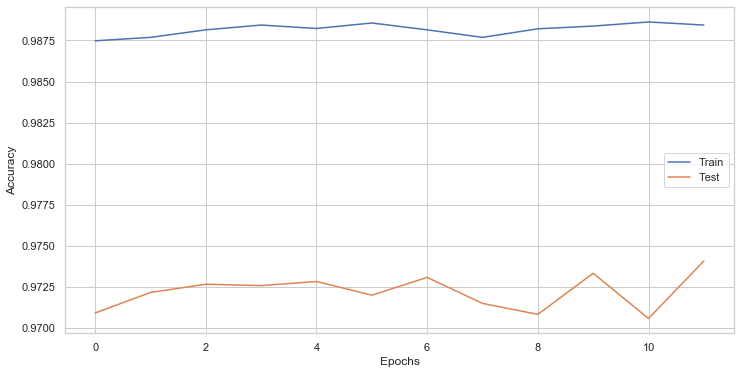

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [38]:
model.save("models/dl/fusion.h5")